In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split  

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Constants

In [3]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
EPOCHS = 30
TEST_DIR_HD = "test/hot_dog"
TEST_DIR_NHD = "test/not_hot_dog"
TRAIN_DIR_HD = "train/hot_dog"
TRAIN_DIR_NHD = "train/not_hot_dog"
DROPOUT = 0.3

In [4]:
# given a directory containing images, will resize the images and store as a numpy array
def image_to_array(dir, ext='.jpg'):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in files:
    if filename.endswith(ext):
      img = cv2.imread(dir + '/' + filename)
      img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
      data.append(img)

  return np.array(data)

## Data Pre-processing

In [5]:
# Normalize image pixels to values between 0-1
# train_hd = image_to_array(TRAIN_DIR_HD) / 255
# train_nhd = image_to_array(TRAIN_DIR_NHD) / 255
# test_hd = image_to_array(TEST_DIR_HD) / 255
# test_nhd = image_to_array(TEST_DIR_NHD) / 255

In [6]:
# Creating training and testing sets
# X_train = np.concatenate((train_hd, train_nhd), axis=0).astype("float32")
# y_train = np.concatenate((np.ones(train_hd.shape[0]), np.zeros(train_nhd.shape[0])), axis=0).astype("float32")

# X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# x_test = np.concatenate((test_hd, test_nhd), axis=0).astype("float32")
# y_test = np.concatenate((np.ones(test_hd.shape[0]), np.zeros(test_nhd.shape[0])), axis=0).astype("float32")
# X_train[0].shape

In [7]:
img_gen_train = ImageDataGenerator(
    brightness_range=[0.2,1.0],
    rotation_range=15,
    zoom_range=0.3,
    data_format="channels_last",
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1.0 / 255,
)

training_generator = img_gen_train.flow_from_directory(
    directory="train",
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    color_mode="rgb",
    batch_size=8,
    class_mode="binary"
)

Found 3810 images belonging to 2 classes.


In [8]:
img_gen_val = ImageDataGenerator(
    rescale=1.0 / 255
)

validation_generator = img_gen_val.flow_from_directory(
    directory="validate",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode="binary",
    batch_size=8
)

Found 598 images belonging to 2 classes.


In [9]:
STEP_SIZE_TRAIN=training_generator.n//training_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

## Build Model

In [10]:
# model_input = tf.keras.Input(shape=training_generator.image_shape)
# base_model = tf.keras.applications.VGG16(include_top=False, input_tensor=model_input)
# base_model.trainable = False
# model = base_model.layers[-1].output
# x = Flatten()(model)
# print(x.shape)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
# # x = Dense(1024, activation="relu")(x)
# # x = Dropout(DROPOUT)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
# out = Dense(1, activation="sigmoid")(x)
# model = tf.keras.Model(inputs=model_input, outputs=out)

In [11]:
model_input = tf.keras.Input(shape=training_generator.image_shape)
x = Conv2D(16, (3,3), activation='relu')(model_input)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(16, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
out = Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=model_input, outputs=out)


In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128   

## Train Model

In [13]:
# hist = model.fit(X_train, y_train, batch_size=64, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=1)
hist = model.fit(training_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=EPOCHS, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID, verbose=1)

Epoch 1/30
476/476 [==============================] - 13s 20ms/step - loss: 0.7425 - accuracy: 0.5561 - val_loss: 0.7096 - val_accuracy: 0.5068
Epoch 2/30
476/476 [==============================] - 8s 18ms/step - loss: 0.6653 - accuracy: 0.5985 - val_loss: 1.0705 - val_accuracy: 0.5608
Epoch 3/30
476/476 [==============================] - 8s 18ms/step - loss: 0.6572 - accuracy: 0.6145 - val_loss: 0.7081 - val_accuracy: 0.6030
Epoch 4/30
476/476 [==============================] - 8s 18ms/step - loss: 0.6607 - accuracy: 0.6206 - val_loss: 0.6761 - val_accuracy: 0.6098
Epoch 5/30
476/476 [==============================] - 8s 18ms/step - loss: 0.6347 - accuracy: 0.6448 - val_loss: 0.7480 - val_accuracy: 0.5152
Epoch 6/30
476/476 [==============================] - 8s 18ms/step - loss: 0.6198 - accuracy: 0.6681 - val_loss: 0.6991 - val_accuracy: 0.6385
Epoch 7/30
476/476 [==============================] - 9s 18ms/step - loss: 0.5956 - accuracy: 0.6968 - val_loss: 0.8459 - val_accuracy: 0.532

## Learning Curve

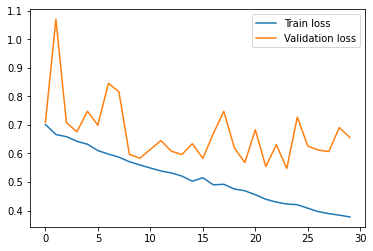

In [14]:
plt.plot(hist.history["loss"], label="Train loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()

## Making Predictions

In [15]:
test_data_generator = ImageDataGenerator(
    rescale=1.0 / 255
)

test_gen = test_data_generator.flow_from_directory(
    directory="test",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode="binary",
    batch_size=1,
    shuffle=False
)

Found 234 images belonging to 2 classes.


In [16]:
test_gen.reset()
labels = test_gen.labels
labels = np.reshape(labels, (labels.shape[0], 1)).astype("float32")
filenames = np.array(test_gen.filenames)
filenames = np.reshape(filenames, (filenames.shape[0], 1))
preds = model.predict(test_gen)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
results = np.concatenate((filenames, labels), axis=1)
results = np.concatenate((results, preds), axis=1)

In [17]:
errors = np.sum(results[:, 1:2] != results[:, 2:3])
classification_acc = 1 - (errors / len(test_gen))
cm = confusion_matrix(results[:, 1:2].flatten(), results[:, 2:3].flatten())
print("Confusion Matrix:")
print(cm)
print(f'Total number of errors: {errors}')
print(f'The classification accuracy for the model is: {round(classification_acc,3) * 100} %')

Confusion Matrix:
[[ 74  43]
 [  8 109]]
Total number of errors: 51
The classification accuracy for the model is: 78.2 %


In [18]:

# predictions = model.predict(x_test)
# predictions[predictions >= 0.5] = 1
# predictions[predictions < 0.5] = 0
# errors = np.sum(y_test != predictions.flatten())
# classification_acc = 1 - (errors / len(y_test))
# cm = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(cm)
# print(f'Total number of errors: {errors}')
# print(f'The classification accuracy for the model is: {round(classification_acc,3) * 100} %')

## Save the model

In [20]:
# model.save("hotdog.h5")